## A simplified version of Fig 5
This notebook contains code that can be used to reproduce the *in silico* portions of Fig 5 from Liu *et al* (*Plos comp bio*) 2018. The code will load in iJL965-ME,  solve it several times with varying amounts of maximum Ni$^{2+}$ allowed, and plot a figure comparing relative Ni$^{2+}$ uptake to growth rate, CODH_ACS protein activity, and CODH4 protein activity.

The figure produced by this code is similar to the final figure presented in the manuscript.  Major differences are the number of data points included (the figure in the manuscript uses 50 data points verses the 10 calculated here) and the level of accuracy (1e-4 verses 1e-9 for the manuscript).  These differences are included so that this notebook would finish running within an hour.  

#### Import packages

In [2]:
import numpy as np
import pandas as pd

from pickle import dump,load
import matplotlib.pyplot as plt

%matplotlib inline

Import COBRAme.  If using the published COBRAme package, please uncomment the first 2 lines of code and remove the last 2 lines of code

In [6]:
from cobrame.solve.algorithms import binary_search
from cobrame.solve.symbolic import compile_expressions

# from minime.solve.algorithms import binary_search
# from minime.solve.symbolic import compile_expressions

#### Load iJL965-ME

In [7]:
me = load(open('iJL965_ME.pickle', 'rb'))

ModuleNotFoundError: No module named 'minime'

#### Set the allowed substrate to CO

In [4]:
me.reactions.EX_co_e.lower_bound = -1000.

## Set the max uptake for alternate substrates to 0 
me.reactions.EX_co2_e.lower_bound = 0.
me.reactions.EX_h2_e.lower_bound = 0.
me.reactions.EX_fru_e.lower_bound = 0.

## Running the model

#### Solve model at maximum growth rate
Here, we set mu_accuracy=1e-4, but the data in the manuscript uses 1e-9

In [5]:
%%capture

expressions = compile_expressions(me)

binary_search(me,
              min_mu=0.368,
              max_mu=0.369,
              mu_accuracy=1e-4,
              compiled_expressions=expressions)

#### Save values of interests

Create variables to save the growth rate and protein activity

In [6]:
columns = []
fluxes = []

Save maximum Ni$^{2+}$ uptake and calculate intervals of Ni$^{2+}$ constraint. Here, we calculate an additional 9 points, but the data in the manuscript includes 50.

In [7]:
max_ex_ni2_e = me.solution.x_dict['EX_ni2_e']
ni_bounds = np.linspace(0, max_ex_ni2_e, 11)[1:-1]

Save maximum growth rate, which will be used to set the upper limit for growth rate in future runs of binary_search() for quicker solving times, as the number of iterations the function must repeat is cut down.

In [8]:
max_gr = me.solution.f

Prepare to calculate protein activity for target metabolic reactions.

In [9]:
def calculate_protein_activity(solution_dict, metabolic_rxns):
    """Calculates the protein activity of metabolic reactions"""
    
    protein_biomass = solution_dict['protein_biomass_to_biomass']
    growth_rate = solution_dict['biomass_dilution']
    
    series = pd.Series(index=metabolic_rxns)
    for rxn in metabolic_rxns:
        protein_activity = abs(solution_dict[rxn]/(protein_biomass/growth_rate))
        series.loc[rxn] = protein_activity
    return series

Define metabolic reactions that require Ni$^{2+}$-containing proteins

In [10]:
metabolic_ni_rxns = ['CODH_ACS_FWD_CODH_AC_SYN_mod_1:4fe4s_mod_1:ni2',
                     'HYD2_FWD_CPLX-27_mod_1:2fe2s_mod_1:ni2',
                     'CODH4_FWD_CPLX-15_mod_1:4fe4s_mod_1:ni2']

Save growth rate and protein activity of Ni$^{2+}$-containing proteins from the maximum growth rate run

In [11]:
ex_ni2_e = me.solution.x_dict['EX_ni2_e']
ni_uptake_ratio = ex_ni2_e/max_ex_ni2_e
columns.append(ni_uptake_ratio)

series = calculate_protein_activity(me.solution.x_dict,
                                    metabolic_ni_rxns)
series.loc['f'] = me.solution.f
fluxes.append(series)

#### Rerun model with Ni$^{2+}$ constrained and save target values

In [12]:
%%capture

previous_gr = 0.1
for ni in ni_bounds:
    ## Constrain the exchange of Ni2+
    me.reactions.EX_ni2_e.lower_bound = ni
    
    ## Run model
    ## The growth rate is rounded off to match mu_accuracy, which is not necessary step
    binary_search(me,
                  min_mu = round(previous_gr, 5),
                  max_mu = round(max_gr, 5),
                  mu_accuracy = 1e-4,
                  compiled_expressions=expressions)
    
    ## Save values of interest
    previous_gr = me.solution.f
    ex_ni2_e = me.solution.x_dict['EX_ni2_e']
    
    ni_uptake_ratio = ex_ni2_e/max_ex_ni2_e
    columns.append(ni_uptake_ratio)

    series = calculate_protein_activity(me.solution.x_dict,
                                        metabolic_ni_rxns)
    series.loc['f'] = me.solution.f
    fluxes.append(series)

## Plotting data

Format data

In [13]:
df = pd.concat(fluxes, axis=1)
df.columns = columns
df[0] = 0  ## Clostridium lljungdahli does not grow without Ni2+ on CO
df.sort_index(axis=1, inplace=True)

Create image

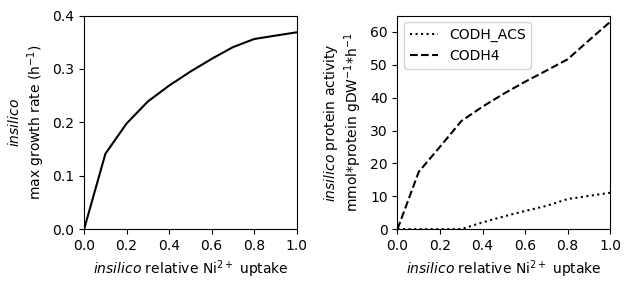

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(6.5, 3))

## Plot relative Ni2+ uptake verses growth rate
axes[0].plot(df.columns, df.loc["f"], 'k-')
axes[0].set(xlim=(0, 1), 
            xlabel=r"$in silico$ relative Ni$^{2+}$ uptake",
            ylim=(0, 0.4), 
            ylabel="\n".join([r"$in silico$",
                              r"max growth rate (h$^{-1}$)"]))

## Plot relative Ni2+ uptake verses protein activity of CODH_ACS and CODH4
## The third Ni2+-containing enzyme, a hydrogenase, has activity of 0
axes[1].plot(df.columns, 
             df.loc['CODH_ACS_FWD_CODH_AC_SYN_mod_1:4fe4s_mod_1:ni2'],
             'k:',
             label='CODH_ACS')
axes[1].plot(df.columns, 
             df.loc['CODH4_FWD_CPLX-15_mod_1:4fe4s_mod_1:ni2'],
             'k--',
             label='CODH4')
axes[1].set(xlim=(0, 1),
            xlabel=r"$in silico$ relative Ni$^{2+}$ uptake",
            ylim=(0, 65),
            ylabel="\n".join([r"$in silico$ protein activity",
                              r"mmol*protein gDW$^{-1}$*h$^{-1}$"]))
axes[1].legend()
fig.tight_layout()

As stated at the top of the notebook, this image differs slightly from Fig 5 in the manuscript due to the number of data points included (10 vs 50) and the level of accuracy (1e-4 vs 1e-9). The user is welcome to modify the code to fully reproduce Fig 5. 

Other modifications to the code, like changing the allowed substrate and checking metabolites being consumed/released, can be used to reproduce any other figure in the manuscript.

### END